In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
from statsmodels.nonparametric.kernel_regression import KernelReg

rng = np.random.default_rng(seed = 100)

In [2]:
## Simulation parameters
T = 1000
mean = 0.0
sigma = .5
beta = .95
N = 1000

## Sample the square
H = 5
X1 = rng.uniform(low=0,high=H,size=N)
X2 = rng.uniform(low=0,high=H,size=N)
X = np.array([X1,X2]).T


In [ ]:


def mu(x1,x2):
    tau = .5
    D = 3
    y = x1 * x2 - tau * ( 1 - np.cos( 5*x1) - np.cos(5*x2))-D
    return y


def simulate_V(policy):
    global y_true
    V = np.zeros(N)
    for t in range(T):
        shocks_t = rng.normal(loc=mean,scale=sigma,size=N)    
        u_t = y_true*policy + shocks_t
        V = u_t + beta*V
    return V


def detect_boundary(policy, delta = .3):
    global X
    policy_bndry = np.zeros(N)
    for i in range(N):
        d_i = np.linalg.norm( X[i] - X, axis=1)
        nbhd_i = np.where(d_i < delta)
        mean_i = np.mean(policy[nbhd_i])
        if mean_i > 0 and mean_i < 1:
            policy_bndry[i] = 1
    return policy_bndry


def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=20)
    plt.show()



def experimental_set( policy_bndry, bndry_fraction = .05, high = 1e5 ):

    bndry_length = int(np.sum(policy_bndry))
    bndry_sample_size = np.floor(bndry_fraction*bndry_length)

    ## Compute delta-neighborhoods:
    adjacency = np.zeros((bndry_length,bndry_length))
    X_bndry = X[policy_bndry.astype(bool),:]
    delta = .5
    for i in range(bndry_length):
        X_bndry_i = X_bndry.copy()
        X_bndry_i[i,:]=np.array([ 10e5, 10e5])
        d_i = np.linalg.norm( X_bndry[i] - X_bndry_i, axis=1)
        nn_i = np.where(d_i < delta)
        adjacency[i,nn_i] = 1

    show_graph_with_labels(adjacency)

    ## Compute max_dist pair:
    max_pair = []
    max_dist = 0
    for i in range(bndry_length):
        X_bndry_i = X_bndry.copy()
        d_i = np.linalg.norm( X_bndry[i] - X_bndry_i, axis=1)
        if np.max(d_i)>max_dist:
            max_pair = [i, np.where(d_i == np.max(d_i)) ]
            max_dist = np.max(d_i)
    max_pair[1] = max_pair[1][0][0]
    
    ## Compute arc costs:
    arc_cost = np.zeros((len(X_bndry), len(X_bndry)))
    for i in range( len(X_bndry) ):
        for j in range( len(X_bndry) ):
            arc_cost[i,j] = (1-adjacency[i,j]) * high + adjacency[i,j] * np.linalg.norm( X_bndry[i] - X_bndry[j] )

    ## Djikstra's
    source_node = max_pair[0]
    J_old = np.ones(len(X_bndry)) * high
    unvisited = np.ones(len(X_bndry))
    J_old = arc_cost[:,source_node]
    count = 0
    while np.sum(unvisited) > 0 & count < 500:
        temp_J = unvisited*J_old + (1-unvisited)*high
        current_node = np.where( temp_J == np.min(temp_J) ) [0][0]
        unvisited[current_node] = 0
        J_new = np.fmin( J_old, J_old[current_node] + arc_cost[:,current_node] ) * unvisited + J_old * (1-unvisited)
        J_old = J_new
        count += 1
    if count ==499:
        print("Djistra's failed")
    d_net = J_old

    ## Pick an experimental net:
    segment_length = max_dist/(bndry_sample_size)
    xp_index = []
    print('bss: ', bndry_sample_size)
    for k in range( int(bndry_sample_size)+1 ):
        window = (d_net > segment_length*(k)) * (d_net <= segment_length*(k+1))
        select = rng.integers(1,np.sum(window))
        index = np.where( np.cumsum(window) == select )[0][0]
        xp_index.append( index )

    xp_net = X_bndry[xp_index]

    return xp_net, xp_index


def RDD_reg(xp_point, X, V, policy):
    Z = X - xp_point
    ## Upper regression
    data_1 = pd.DataFrame({ 'V':V[policy==1],
                        'z1':Z[policy==1,0],
                            'z2':Z[policy==1, 1],    })
    reg_1 = KernelReg(endog = V[policy==1], # This is the problem command: Need an IK style
                    exog = data_1.drop('V',axis=1),
                    var_type = ['c','c'])
    tau_upper = reg_1.fit([0,0])[0]
    ## Lower regression
    data_0 = pd.DataFrame({ 'V':V[policy==0],
                        'z1':Z[policy==0,0],
                            'z2':Z[policy==0, 1],    })
    reg_1 = KernelReg(endog = V[policy==0],
                    exog = data_0.drop('V',axis=1),
                    var_type = ['c','c'])
    tau_lower = reg_1.fit([0,0])[0]
    ## Effect size:
    effect = tau_upper - tau_lower
    return effect


def est_net_fx(V,policy, xp_net):
    
    data_1 = pd.DataFrame({ 'V':V[policy==1],
                        'x1':X1[policy==1],
                            'x2':X2[policy==1],    })

    data_0 = pd.DataFrame({ 'V':V[policy==0],
                        'x1':X1[policy==0],
                            'x2':X2[policy==0],    })

    net_fx = []
    for j in range( len(xp_net) ):
        print( str(j) +' of '+ str( len(xp_net) ) )
        fx_j = RDD_reg( xp_net[j], X, V, policy)
        net_fx.append( fx_j )
    
    return net_fx



def policy_update(policy_old, net_fx, xp_net):
    policy_new = policy_old.copy()
    delta = .25
    tol = .05

    for k in range(len(net_fx)):
        if net_fx[k]>tol:
            d_k = np.linalg.norm( xp_net[k,:] - X, axis=1)
            nbhd_k = np.where(d_k < delta)
            policy_new[nbhd_k] = 1
        elif net_fx[k]<tol:
            d_k = np.linalg.norm( xp_net[k,:] - X, axis=1)
            nbhd_k = np.where(d_k < -delta)
            policy_new[nbhd_k] = 0
    policy_delta = ( policy_new != policy_old )
    sns.scatterplot( x=X1,y=X2,hue=policy_delta).set(title='Policy $\\Delta$')
    plt.show()
    sns.scatterplot( x=X1,y=X2,hue=policy_new).set(title='New Policy')
    plt.show()
    return policy_new



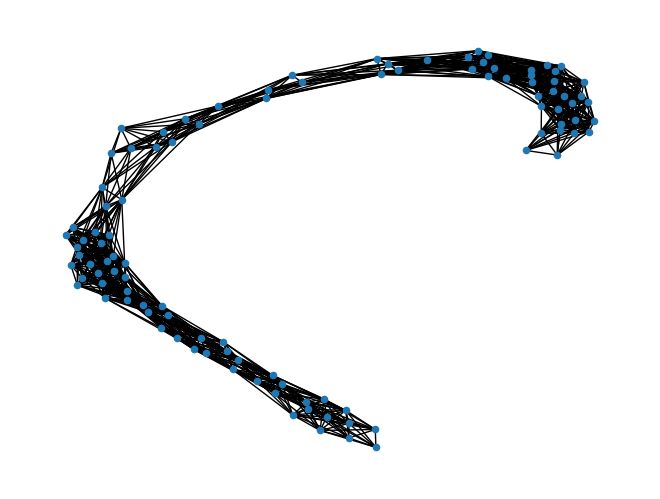

bss:  5.0
0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


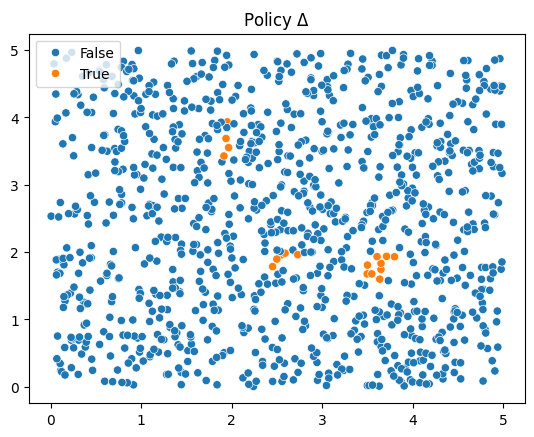

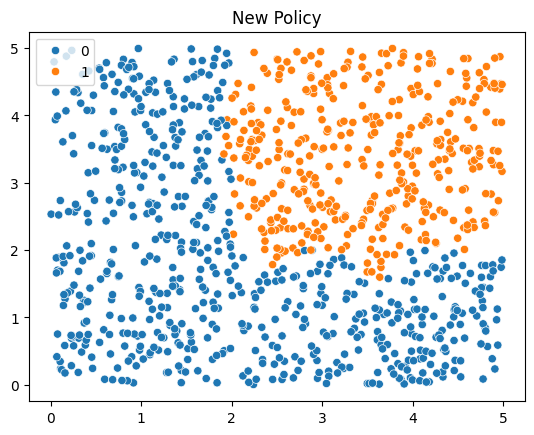

Iteration:  1


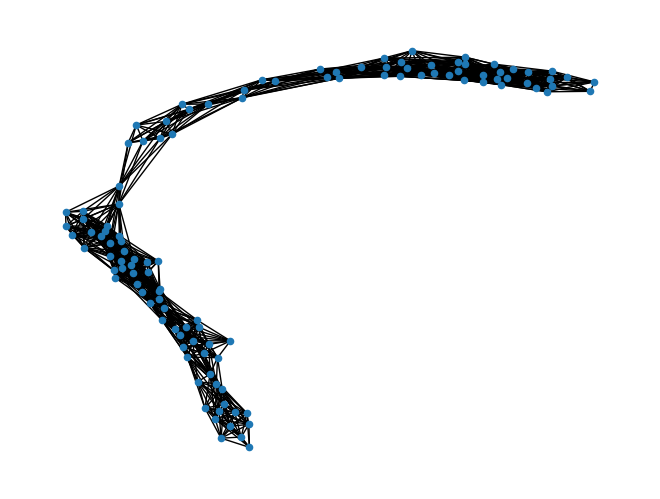

bss:  5.0
0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


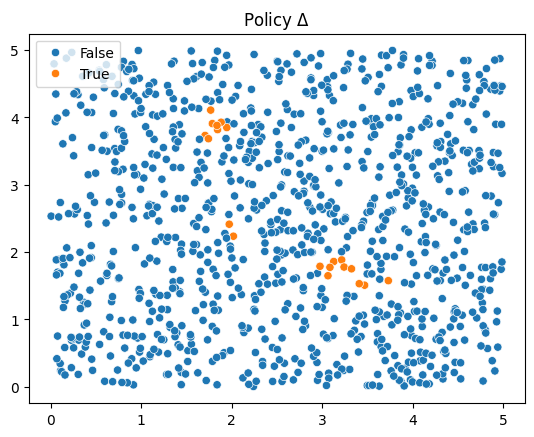

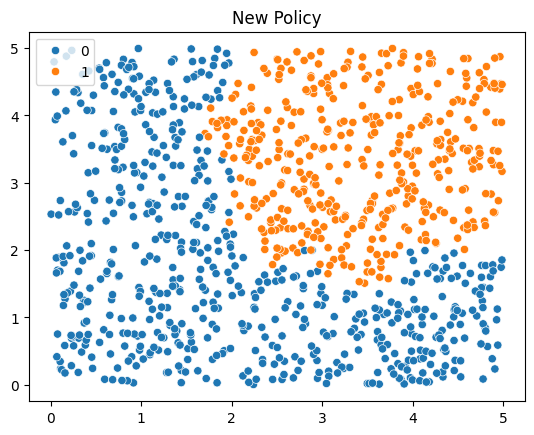

Iteration:  2


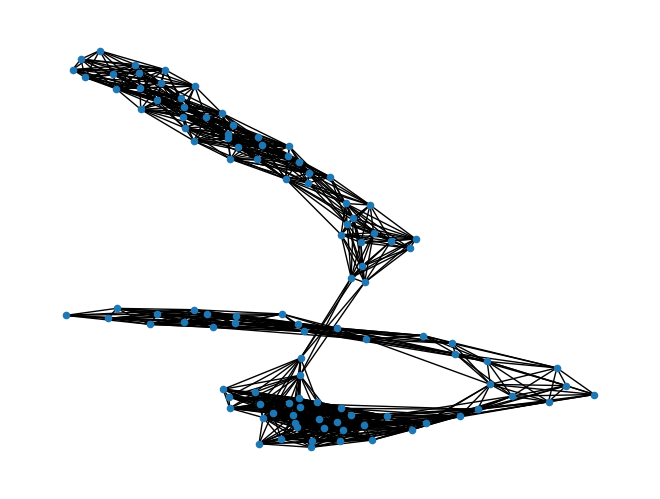

bss:  5.0
0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


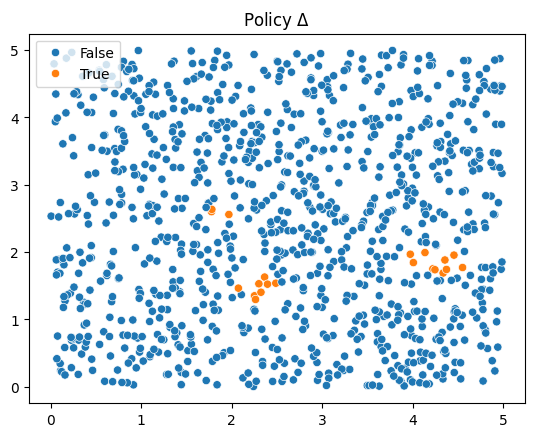

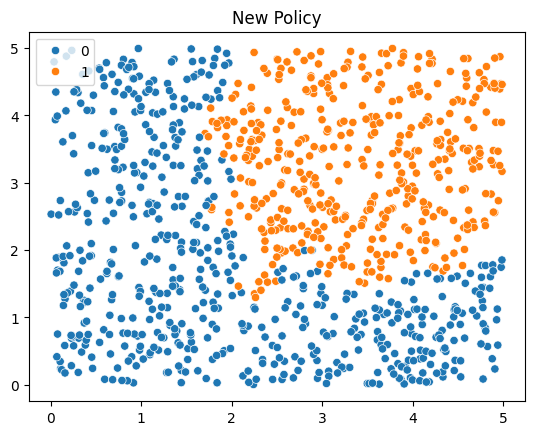

Iteration:  3


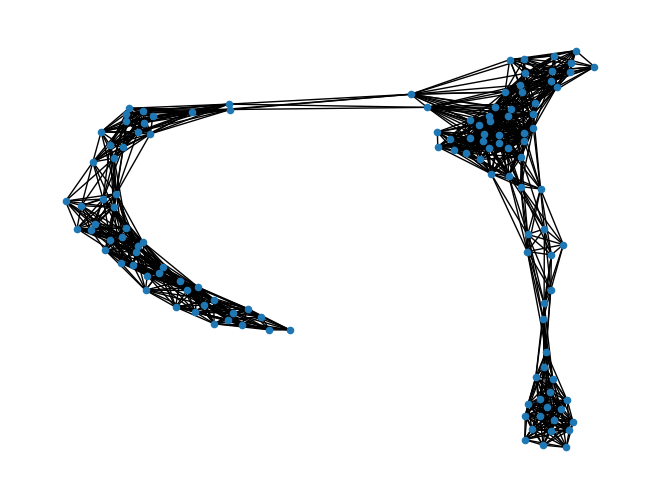

bss:  6.0
0 of 7
1 of 7
2 of 7
3 of 7
4 of 7
5 of 7
6 of 7


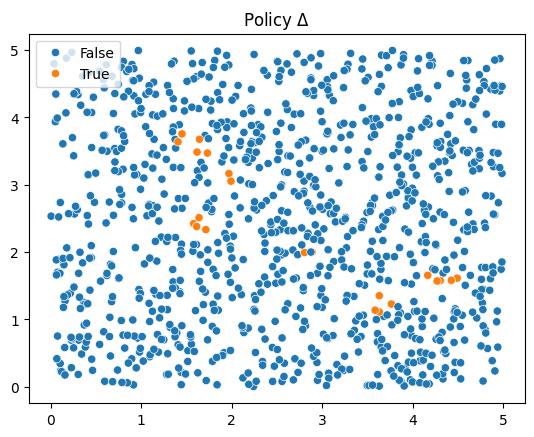

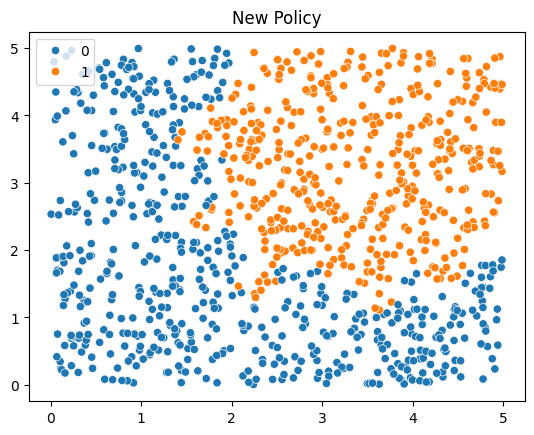

Iteration:  4


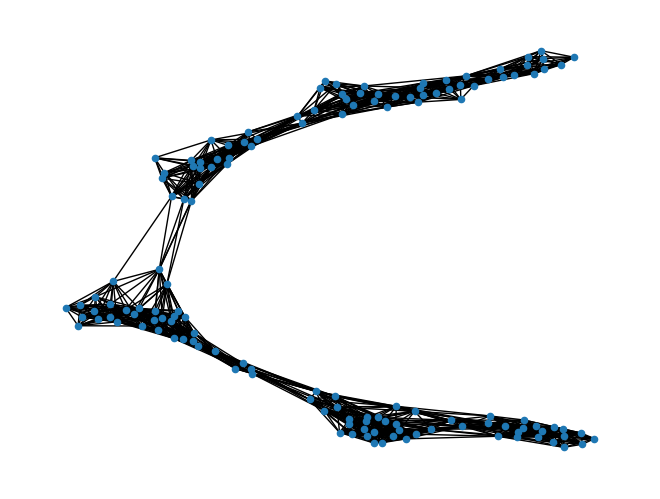

bss:  7.0
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8


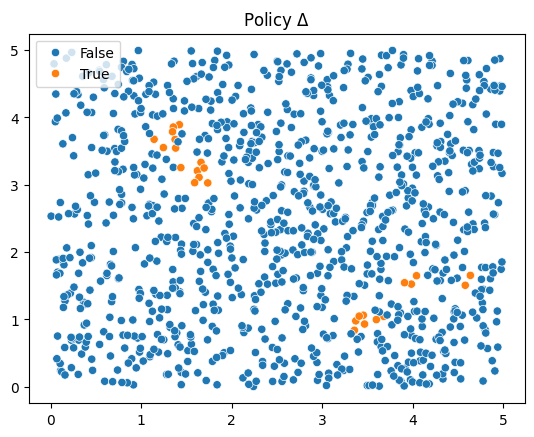

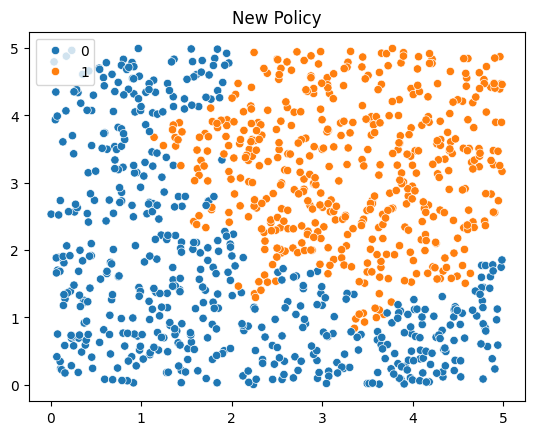

Iteration:  5


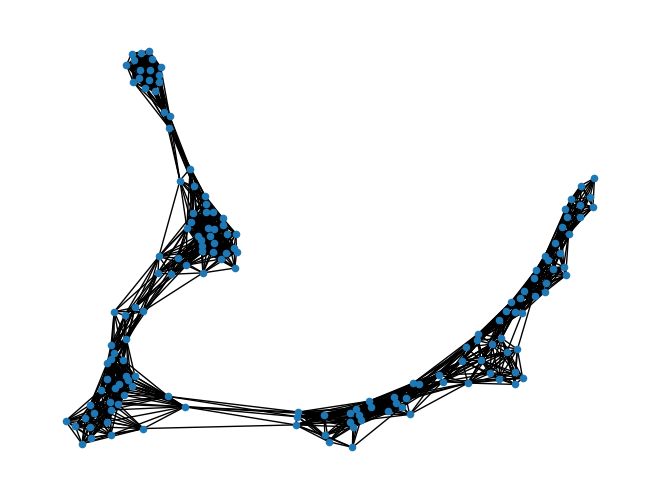

bss:  7.0
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8


KeyboardInterrupt: 

In [4]:
## True return function
y_true = mu(X1,X2)

## Initial Policy:
policy_old =  np.array( (X1>2)*(X2>2) ).astype(int) 

count = 0
stop_now = False
while stop_now is False:
    
    ## Detect policy
    policy_bndry = detect_boundary(policy_old)

    #print(policy_bndry) # Looks fine

    ## Experimental points
    xp_net, xp_index = experimental_set( policy_bndry ) 

    ## Gather data
    V_hat = simulate_V(policy_old)
    net_fx = est_net_fx(V_hat, policy_old, xp_net)

    ## Policy update
    policy_new = policy_update(policy_old, net_fx, xp_net)

    ## Check convergence
    stop_now = np.array_equal( policy_new, policy_old)
        # This stopping condition is too simplistic: Might miss some points that need reconsidering
        # Generate an ongoing boundary set from which to draw experimental points?
        # Kick out previously experimental points

    ## Update
    policy_old = policy_new.copy()
    count += 1
    print('Iteration: ', count)



In [ ]:
         
# fraction = .05
# high = 1e5 
# bndry_fraction = .05

# bndry_length = int(np.sum(policy_bndry))
# bndry_sample_size = np.floor(bndry_fraction*bndry_length)


# ## Compute delta-neighborhoods:
# adjacency = np.zeros((bndry_length,bndry_length))
# X_bndry = X[policy_bndry.astype(bool),:]
# delta = .5
# for i in range(bndry_length):
#     X_bndry_i = X_bndry.copy()
#     X_bndry_i[i,:]=np.array([ 10e5, 10e5])
#     d_i = np.linalg.norm( X_bndry[i] - X_bndry_i, axis=1)
#     nn_i = np.where(d_i < delta)
#     adjacency[i,nn_i] = 1

# show_graph_with_labels(adjacency)

# ## Compute max_dist pair:
# max_pair = []
# max_dist = 0
# for i in range(bndry_length):
#     X_bndry_i = X_bndry.copy()
#     d_i = np.linalg.norm( X_bndry[i] - X_bndry_i, axis=1)
#     if np.max(d_i)>max_dist:
#         max_pair = [i, np.where(d_i == np.max(d_i)) ]
#         max_dist = np.max(d_i)
# max_pair[1] = max_pair[1][0][0]


# ## Compute arc costs:
# arc_cost = np.zeros((len(X_bndry), len(X_bndry)))
# for i in range( len(X_bndry) ):
#     for j in range( len(X_bndry) ):
#         arc_cost[i,j] = (1-adjacency[i,j]) * high + adjacency[i,j] * np.linalg.norm( X_bndry[i] - X_bndry[j] )

# ## Djikstra's
# source_node = max_pair[0]
# J_old = np.ones(len(X_bndry)) * high
# unvisited = np.ones(len(X_bndry))
# J_old = arc_cost[:,source_node]
# while np.sum(unvisited) > 0:
#     temp_J = unvisited*J_old + (1-unvisited)*high
#     current_node = np.where( temp_J == np.min(temp_J) ) [0][0]
#     unvisited[current_node] = 0
#     J_new = np.fmin( J_old, J_old[current_node] + arc_cost[:,current_node] ) * unvisited + J_old * (1-unvisited)
#     J_old = J_new
# d_net = J_old

# ## Pick an experimental net:
# segment_length = max_dist/(bndry_sample_size)
# xp_index = []
# for k in range( int(bndry_sample_size)+1 ):
#     window = (d_net > segment_length*(k)) * (d_net <= segment_length*(k+1))
#     select = rng.integers(1,np.sum(window))
#     index = np.where( np.cumsum(window) == select )[0][0]
#     xp_index.append( index )

# xp_net = X_bndry[xp_index]

